# **NEV Energy Management Dataset - Classification**

## About Dataset

**Introduction**

The NEV Energy Management Dataset is designed to support research on optimizing energy management strategies for New Energy Vehicles (NEVs) using Multi-Agent Reinforcement Learning (MARL). The dataset captures realistic driving conditions, power distribution, fuel consumption, and battery health across different driving cycles.


**Key Features**

- 1000 samples of vehicle energy consumption and management data.
- Covers standard driving cycles: WLTC (World Light Vehicle Test Cycle) and HWFET (Highway Fuel Economy Test).
- Energy distribution between the engine and battery for hybrid vehicle optimization.
- Fuel consumption trends under dynamic driving conditions.
- Battery degradation monitoring based on high-power discharge events.
- Target column (Energy Efficiency Class) categorizes vehicles into High, Medium, or Low Efficiency based on fuel use and battery degradation.

**Provider:** Ziya

**Reference:** https://www.kaggle.com/datasets/ziya07/nev-energy-management-dataset/data

## About this notebook

For this notebook, we will build classifiers for Energy Efficiency Class. Our model includes <font color=orange>SVC, Decision Tree, Random Forest, Extra Trees, AdaBoost, Gradient Boost, XGBoost, LightGBM and CatBoost.

## Setup

In [1]:
import pandas as pd
import numpy as np

# Figure
import matplotlib.pyplot as plt
import ipywidgets as widgets
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

**When we import "imblearn.over_sampling" the error occurs for <font color = red>cannot import name 'validate_data' from 'sklearn.utils.validation'</font>. Use the following method to update 'scikit-learn' and 'imbalanced-learn' to solve the problem.**

In [2]:
#conda update scikit-learn imbalanced-learn

## Importing the dataset

In [3]:
filepath = "C:/Users/User/My Porject (Jupyter notebook)/Database/nev_energy_management_dataset.csv"

df = pd.read_csv(filepath, header=0)

In [4]:
# show the first 5 rows using dataframe.head() method
print("The first 5 rows of the dataframe") 
df.head(5)

The first 5 rows of the dataframe


,Time (s),Speed (km/h),Acceleration (m/s²),Power Demand (kW),Engine Power (kW),Battery Power (kW),Fuel Consumption (L/100km),SOC (%),Battery Degradation (%),Regenerative Braking Power (kW),Total Energy Used (kWh),Driving Cycle Type,Target Efficiency
0,0,57.450712,-0.211880,43.215053,22.336935,20.878118,4.376824,99.979122,0.002088,2.832156,46.047209,WLTC,High Efficiency
1,1,47.926035,-0.226707,46.945005,18.990768,27.954237,2.995502,99.951168,0.004883,2.873574,49.818579,HWFET,High Efficiency
2,2,59.715328,-0.897822,44.026189,29.474738,14.551452,2.091800,99.936616,0.006338,2.336560,46.362750,Urban,High Efficiency
3,3,72.845448,-0.165045,51.104180,28.521918,22.582263,3.296834,99.914034,0.008597,3.439032,54.543212,Highway,High Efficiency
4,4,46.487699,0.366415,61.971785,40.587843,21.383942,5.963712,99.892650,0.010735,0.000000,61.971785,WLTC,Low Efficiency


Get information of dataframe.

In [5]:
def get_df_info(df):
    print("\n\033[1mShape of DataFrame:\033[0m ", df.shape)
    print("\n\033[1mColumns in DataFrame:\033[0m ", df.columns.to_list())
    print("\n\033[1mData types of columns:\033[0m\n", df.dtypes)
    
    print("\n\033[1mInformation about DataFrame:\033[0m")
    df.info()
    
    print("\n\033[1mNumber of unique values in each column:\033[0m")
    for col in df.columns:
        print(f"\033[1m{col}\033[0m: {df[col].nunique()}")
        
    print("\n\033[1mNumber of null values in each column:\033[0m\n", df.isnull().sum())
    
    print("\n\033[1mNumber of duplicate rows:\033[0m ", df.duplicated().sum())
    
    print("\n\033[1mDescriptive statistics of DataFrame:\033[0m\n", df.describe().transpose())

# Call the function
get_df_info(df)


Shape of DataFrame:  (5000, 13)

Columns in DataFrame:  ['Time (s)', 'Speed (km/h)', 'Acceleration (m/s²)', 'Power Demand (kW)', 'Engine Power (kW)', 'Battery Power (kW)', 'Fuel Consumption (L/100km)', 'SOC (%)', 'Battery Degradation (%)', 'Regenerative Braking Power (kW)', 'Total Energy Used (kWh)', 'Driving Cycle Type', 'Target Efficiency']

Data types of columns:
 Time (s)                             int64
Speed (km/h)                       float64
Acceleration (m/s²)                float64
Power Demand (kW)                  float64
Engine Power (kW)                  float64
Battery Power (kW)                 float64
Fuel Consumption (L/100km)         float64
SOC (%)                            float64
Battery Degradation (%)            float64
Regenerative Braking Power (kW)    float64
Total Energy Used (kWh)            float64
Driving Cycle Type                  object
Target Efficiency                   object
dtype: object

Information about DataFrame:
<class 'pandas.core.frame.

## EDA

### Distribution of Features

In [6]:
# Define a function to plot the disctribution of features
def plot_feature(feature):
    plt.figure(figsize=(10,6))
    df[feature].hist(bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

# Create a dropdown widget with the dataframe's column names
dropdown = widgets.Dropdown(options=df.columns, description='Feature:')

# Use the interact function to create the widget and the plot
widgets.interact(plot_feature, feature=dropdown);

interactive(children=(Dropdown(description='Feature:', options=('Time (s)', 'Speed (km/h)', 'Acceleration (m/s…

### Heatmap

Label encoding for target column 'Target Efficiency'.

In [11]:
df_le = df.copy('Deep')
df_le["Target Efficiency"]=df_le["Target Efficiency"].map({'Low Efficiency': 0, 'Medium Efficiency': 1,'High Efficiency':2})
df_le

,Time (s),Speed (km/h),Acceleration (m/s²),Power Demand (kW),Engine Power (kW),Battery Power (kW),Fuel Consumption (L/100km),SOC (%),Battery Degradation (%),Regenerative Braking Power (kW),Total Energy Used (kWh),Driving Cycle Type,Target Efficiency
0,0,57.450712,-0.211880,43.215053,22.336935,20.878118,4.376824,99.979122,0.002088,2.832156,46.047209,WLTC,2
1,1,47.926035,-0.226707,46.945005,18.990768,27.954237,2.995502,99.951168,0.004883,2.873574,49.818579,HWFET,2
2,2,59.715328,-0.897822,44.026189,29.474738,14.551452,2.091800,99.936616,0.006338,2.336560,46.362750,Urban,2
3,3,72.845448,-0.165045,51.104180,28.521918,22.582263,3.296834,99.914034,0.008597,3.439032,54.543212,Highway,2
4,4,46.487699,0.366415,61.971785,40.587843,21.383942,5.963712,99.892650,0.010735,0.000000,61.971785,WLTC,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,49.265525,0.650551,40.903480,20.732374,20.171106,4.925593,20.000000,10.000000,0.000000,40.903480,Urban,0
4996,4996,60.671159,-0.999172,62.371510,29.878013,32.493497,4.752956,20.000000,10.000000,9.532414,71.903924,Urban,0
4997,4997,96.693653,-0.352658,63.122080,36.863992,26.258088,3.339200,20.000000,10.000000,6.935045,70.057125,Urban,0
4998,4998,62.120543,0.247883,41.158909,20.718179,20.440729,3.768070,20.000000,10.000000,0.000000,41.158909,HWFET,0


Drop the category feature "Driving Cycle Type".

In [12]:
df_le_corr=df_le.drop('Driving Cycle Type', axis=1)

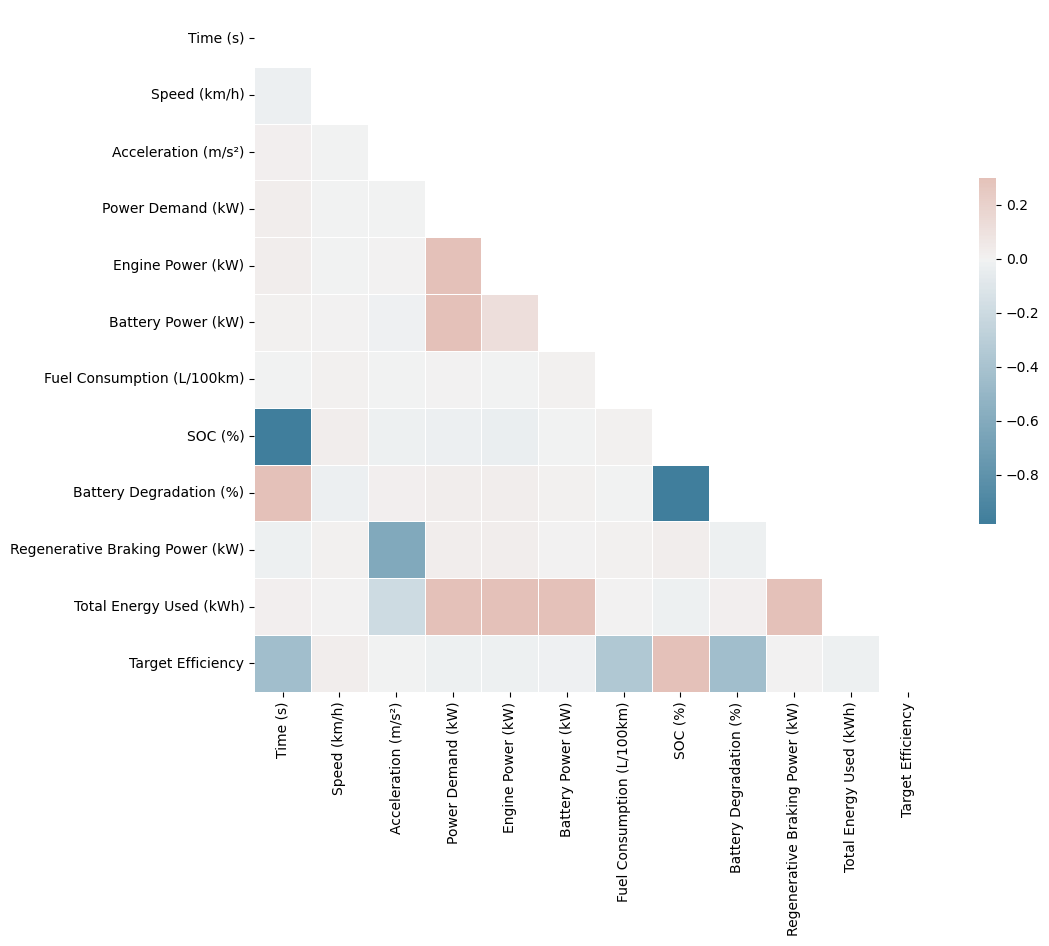

In [13]:
# Compute the correlation matrix
corr = df_le_corr.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

## Model Building

In [15]:
# Define the features and the target
X = df_le.drop('Target Efficiency', axis=1)
y = df_le['Target Efficiency']

One hot encoding for category feature "Driving Cycle Type".

In [16]:
X = pd.get_dummies(X)
pd.DataFrame(X)

,Time (s),Speed (km/h),Acceleration (m/s²),Power Demand (kW),Engine Power (kW),Battery Power (kW),Fuel Consumption (L/100km),SOC (%),Battery Degradation (%),Regenerative Braking Power (kW),Total Energy Used (kWh),Driving Cycle Type_HWFET,Driving Cycle Type_Highway,Driving Cycle Type_Urban,Driving Cycle Type_WLTC
0,0,57.450712,-0.211880,43.215053,22.336935,20.878118,4.376824,99.979122,0.002088,2.832156,46.047209,False,False,False,True
1,1,47.926035,-0.226707,46.945005,18.990768,27.954237,2.995502,99.951168,0.004883,2.873574,49.818579,True,False,False,False
2,2,59.715328,-0.897822,44.026189,29.474738,14.551452,2.091800,99.936616,0.006338,2.336560,46.362750,False,False,True,False
3,3,72.845448,-0.165045,51.104180,28.521918,22.582263,3.296834,99.914034,0.008597,3.439032,54.543212,False,True,False,False
4,4,46.487699,0.366415,61.971785,40.587843,21.383942,5.963712,99.892650,0.010735,0.000000,61.971785,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,49.265525,0.650551,40.903480,20.732374,20.171106,4.925593,20.000000,10.000000,0.000000,40.903480,False,False,True,False
4996,4996,60.671159,-0.999172,62.371510,29.878013,32.493497,4.752956,20.000000,10.000000,9.532414,71.903924,False,False,True,False
4997,4997,96.693653,-0.352658,63.122080,36.863992,26.258088,3.339200,20.000000,10.000000,6.935045,70.057125,False,False,True,False
4998,4998,62.120543,0.247883,41.158909,20.718179,20.440729,3.768070,20.000000,10.000000,0.000000,41.158909,True,False,False,False


**The code below will apply each model to our data, calculate the accuracy and F1 score, and store the performance in a dictionary. It then sorts the models based on F1 score and picks the top 3. These top 3 models are used to create a Voting Classifier and a Stacking Classifier, and the performance of these classifiers is evaluated.**

In [17]:
def apply_models(X, y):
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Check for class imbalance
    class_counts = np.bincount(y_train)
    if len(class_counts) > 2 or np.min(class_counts) / np.max(class_counts) < 0.1:
      print("Class imbalance detected. Applying SMOTE...")
    
    # Apply SMOTE (class imbalance)
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    
    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Fit the scaler on the training data and transform both training and test data
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Define the models
    models = {
        'LogisticRegression': LogisticRegression(class_weight='balanced'),
        'SVC': SVC(class_weight='balanced'),
        'DecisionTree': DecisionTreeClassifier(class_weight='balanced'),
        'RandomForest': RandomForestClassifier(class_weight='balanced'),
        'ExtraTrees': ExtraTreesClassifier(class_weight='balanced'),
        'AdaBoost': AdaBoostClassifier(),
        'GradientBoost': GradientBoostingClassifier(),
        'XGBoost': XGBClassifier(scale_pos_weight=sum(y_train == 0) / sum(y_train == 1), use_label_encoder=False, eval_metric='logloss'),
        'LightGBM': LGBMClassifier(),
        'CatBoost': CatBoostClassifier(auto_class_weights='Balanced', verbose=0)
    }

    # Initialize a dictionary to hold the performance of each model
    model_performance = {}

    # Apply each model
    for model_name, model in models.items():
        print(f"\n\033[1mClassification with {model_name}:\033[0m\n{'-' * 30}")
        
        # Fit the model to the training data
        model.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = model.predict(X_test)

        # Calculate the accuracy and f1 score
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Store the performance in the dictionary
        model_performance[model_name] = (accuracy, f1)

        # Print the accuracy score
        print("\033[1m**Accuracy**:\033[0m\n", accuracy)

        # Print the confusion matrix
        print("\n\033[1m**Confusion Matrix**:\033[0m\n", confusion_matrix(y_test, y_pred))

        # Print the classification report
        print("\n\033[1m**Classification Report**:\033[0m\n", classification_report(y_test, y_pred))

    # Sort the models based on f1 score and pick the top 3
    top_3_models = sorted(model_performance.items(), key=lambda x: x[1][1], reverse=True)[:3]
    print("\n\033[1mTop 3 Models based on F1 Score:\033[0m\n", top_3_models)

    # Extract the model names and classifiers for the top 3 models
    top_3_model_names = [model[0] for model in top_3_models]
    top_3_classifiers = [models[model_name] for model_name in top_3_model_names]

    # Create a Voting Classifier with the top 3 models
    print("\n\033[1mInitializing Voting Classifier with top 3 models...\033[0m\n")
    voting_clf = VotingClassifier(estimators=list(zip(top_3_model_names, top_3_classifiers)), voting='hard')
    voting_clf.fit(X_train, y_train)
    y_pred = voting_clf.predict(X_test)
    print("\n\033[1m**Voting Classifier Evaluation**:\033[0m\n")
    print("\033[1m**Accuracy**:\033[0m\n", accuracy_score(y_test, y_pred))
    print("\n\033[1m**Confusion Matrix**:\033[0m\n", confusion_matrix(y_test, y_pred))
    print("\n\033[1m**Classification Report**:\033[0m\n", classification_report(y_test, y_pred))

    # Create a Stacking Classifier with the top 3 models
    print("\n\033[1mInitializing Stacking Classifier with top 3 models...\033[0m\n")
    stacking_clf = StackingClassifier(estimators=list(zip(top_3_model_names, top_3_classifiers)))
    stacking_clf.fit(X_train, y_train)
    y_pred = stacking_clf.predict(X_test)
    print("\n\033[1m**Stacking Classifier Evaluation**:\033[0m\n")
    print("\033[1m**Accuracy**:\033[0m\n", accuracy_score(y_test, y_pred))
    print("\n\033[1m**Confusion Matrix**:\033[0m\n", confusion_matrix(y_test, y_pred))
    print("\n\033[1m**Classification Report**:\033[0m\n", classification_report(y_test, y_pred))

In [18]:
apply_models(X, y)

Class imbalance detected. Applying SMOTE...

Classification with LogisticRegression:
------------------------------
**Accuracy**:
 0.852

**Confusion Matrix**:
 [[714  23  40]
 [ 71   0   0]
 [ 14   0 138]]

**Classification Report**:
               precision    recall  f1-score   support

           0       0.89      0.92      0.91       777
           1       0.00      0.00      0.00        71
           2       0.78      0.91      0.84       152

    accuracy                           0.85      1000
   macro avg       0.56      0.61      0.58      1000
weighted avg       0.81      0.85      0.83      1000


Classification with SVC:
------------------------------
**Accuracy**:
 0.93

**Confusion Matrix**:
 [[723  34  20]
 [  6  65   0]
 [ 10   0 142]]

**Classification Report**:
               precision    recall  f1-score   support

           0       0.98      0.93      0.95       777
           1       0.66      0.92      0.76        71
           2       0.88      0.93      0.90 

<font color=red>Note that logistic regression is applicable to binary classification. In this problem, there are three target categories, so the results of logistic classification should be ignored.